In [73]:
from torch import nn,save,load
from torch.optim import Adam
from torch.utils.data import DataLoader 
from torchvision import datasets
from torchvision.transforms import ToTensor

In [24]:
train  = datasets.MNIST(root="data",download=True,train=True,transform=ToTensor())

In [74]:
dataset = DataLoader(train,32)
#image shape (1,28,28)

In [75]:
#0-9 classes
class ImageClassification(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(1,32,(3,3)),
        nn.ReLU (),
        nn.Conv2d(32,64,(3,3)),
        nn.ReLU (),
        nn.Conv2d(64,64,(3,3)),
        nn.ReLU (),
        nn.Flatten(),
        nn.Linear(64*(28-6)*(28-6),10))
  def forward(self,x):
    return self.model(x)

In [76]:
!nvidia-smi

Sun Dec 18 13:53:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    27W /  70W |   1224MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [77]:
#creating instance of NN loss and Optimizer
clf = ImageClassification().to('cuda')
opt = Adam(clf.parameters(),lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()

In [78]:
#Training Function
from tqdm import tqdm

if __name__ == "__main__":
  #run Dl for no.of epoch 
  for epoch in range(10): #trains for 10 epoch
    for batch in tqdm(dataset):
      X,y = batch
      X, y = X.to('cuda'), y.to('cuda')
      yhat = clf(X)
      loss = loss_fn(yhat,y)

      #apply backprop
      opt.zero_grad()
      loss.backward()
      opt.step()

  print(f"Epoch:{epoch} loss is {loss.item()}")

with open('model_state.pt','wb') as f:
  save(clf.state_dict(),f)

100%|██████████| 1875/1875 [00:10<00:00, 174.89it/s]

Epoch:9 loss is 5.587896794168046e-07


In [79]:
with open('model_state.pt','wb') as f:
  save(clf.state_dict(),f)

tensor(7, device='cuda:0')


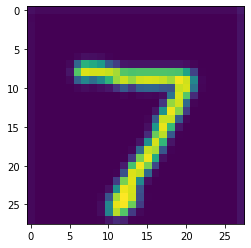

In [80]:
import matplotlib.pyplot as plt
import torch 
from PIL import Image
with open('/content/model_state.pt',"rb") as f:
  clf.load_state_dict(load(f))
image = Image.open('/content/sample_image.jpg')
img = image.convert('L')
#reshaping to weight 1,3,1480,1490
img = img.resize((28,28))
img_tensor = ToTensor()(img).unsqueeze(0).to('cuda')

print(torch.argmax(clf(img_tensor)))
plt.imshow(img)


In [91]:
import torch
from torch.autograd import Variable 
dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor #to run on gpu

N, D_in , H, D_out = 64, 1000,100,10
x = Variable(torch.randn(N,D_in).type(dtype), requires_grad=False)
y = Variable(torch.randn(N,D_out).type(dtype), requires_grad=False)

w1 = Variable(torch.randn(D_in,H).type(dtype), requires_grad=True)
w2 = Variable(torch.randn(H,D_out).type(dtype), requires_grad=True)

In [92]:
learning_rate = 1e-6
for t in range(500):
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
    ##mm is matrix multiplication and clamp , clamps both all the values in the input range between a min and max values

    #calculate loss
    '''Now to compute the loss we are using the same popular loss function , sum of all squared difference of y_pred and y 
Loss is a variable of shape(1,) and loss.data is a Tensor of shape (1,) ; loss.data[0] is a scalar value holding loss'''
    loss = (y_pred - y).pow(2).sum()
    print(t, loss.data)
    '''Now we need to set the gradients of both sets of weights to 0 since graident buffers needs to be reset before fresh gradients are calculated'''

    '''now we will use autograd to compute the backward pass . this call will compute the gradient of loss wrt all variables with ```requires_grad=True``` 
after this w1.grad and w2.grad will be variables holding the grad of the loss wrt w1 and w2'''
    loss.backward()

    '''now we will update the weights using gradient descent . for this we will just mutate the values of w1 and w2 in place .'''
    w1.data -= learning_rate*w1.grad.data
    w2.data -= learning_rate*w2.grad.data
    w1.grad.data.zero_()
    w2.grad.data.zero_()

0 tensor(30291956., device='cuda:0')
1 tensor(24736454., device='cuda:0')
2 tensor(20468336., device='cuda:0')
3 tensor(15928928., device='cuda:0')
4 tensor(11420418., device='cuda:0')
5 tensor(7666515.5000, device='cuda:0')
6 tensor(4994868., device='cuda:0')
7 tensor(3276403., device='cuda:0')
8 tensor(2225308., device='cuda:0')
9 tensor(1586841., device='cuda:0')
10 tensor(1189338.2500, device='cuda:0')
11 tensor(930999.1875, device='cuda:0')
12 tensor(753996.2500, device='cuda:0')
13 tensor(626136.4375, device='cuda:0')
14 tensor(529501.7500, device='cuda:0')
15 tensor(453962.1250, device='cuda:0')
16 tensor(393252.5625, device='cuda:0')
17 tensor(343291.0625, device='cuda:0')
18 tensor(301485.1250, device='cuda:0')
19 tensor(266104.3438, device='cuda:0')
20 tensor(235886.3750, device='cuda:0')
21 tensor(209892.9688, device='cuda:0')
22 tensor(187390.1562, device='cuda:0')
23 tensor(167820.3750, device='cuda:0')
24 tensor(150729.2031, device='cuda:0')
25 tensor(135729.9375, device=

In [93]:
train  = datasets.MNIST(root="data",download=True,train=True,transform=ToTensor())
dataset = DataLoader(train,32)
#image shape (1,28,28)

In [98]:
#trying using MyReLU
class MyReLU(nn.Module):
    def forward(self, input):
        self.save_for_backward(input)
        return input.clamp(min=0)
    def backward(self, grad_output):
        input, = self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input<0] = 0
        return grad_input
    def save_for_backward(self,x):
        self.saved_tensors = x
#0-9 classes
class ImageClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1,32,(3,3)),
            MyReLU(),
            nn.Conv2d(32,64,(3,3)),
            MyReLU(),
            nn.Conv2d(64,64,(3,3)),
            MyReLU(),
            nn.Flatten(),
            nn.Linear(64*(28-6)*(28-6),10))
    def forward(self,x):
        return self.model(x)

#creating instance of NN loss and Optimizer
clf = ImageClassification().to('cuda')
opt = Adam(clf.parameters(),lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()

In [99]:
#Training Function
from tqdm import tqdm

if __name__ == "__main__":
  #run Dl for no.of epoch 
  for epoch in range(10): #trains for 10 epoch
    for batch in tqdm(dataset):
      X,y = batch
      X, y = X.to('cuda'), y.to('cuda')
      yhat = clf(X)
      loss = loss_fn(yhat,y)

      #apply backprop
      opt.zero_grad()
      loss.backward()
      opt.step()

  print(f"Epoch{epoch} loss is {loss.item()}")

with open('model_state.pt','wb') as f:
  save(clf.state_dict(),f)

100%|██████████| 1875/1875 [00:11<00:00, 163.81it/s]

Epoch9 loss is 3.725273245436256e-07


In [99]:
with open('model_state.pt','wb') as f:
  save(clf.state_dict(),f)

tensor(5, device='cuda:0')


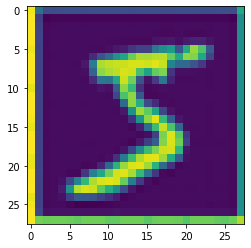

In [107]:
#predicting
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def predict(img,model):
    x = ToTensor()(img).unsqueeze(0).to('cuda')
    yhat = model(x)
    return yhat.argmax()

img = Image.open('/content/0_oHxOGD8nrUN4e5-x.png')
#convertin to 1 channel
img = img.convert('L')
#reshaping to weight 1,3,1480,1490
img = img.resize((28,28))
plt.imshow(img)
print(predict(img,clf))